## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

I started by preparing object points, which are x,y,z coordinates of chessboard corner. Since I am using a chessboard image, so the value of z will be 0. I have used some images of chessboard taken with a same camera from different angles and for each image I am calling cv2.findChessboardCorners() method to find corners in chessboard image then I am using these corners with the imagepoints to calibrate the camera using cv2.calibrateCamera() method which returns the distortion coefficients. Then I called cv2.undistort method which uses these distortion coefficients to undistort the images.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

In [2]:
def computeCalibrationMatrix(images):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    image_shape = None

    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            image_shape = img.shape
    return cv2.calibrateCamera(objpoints, imgpoints, image_shape[1::-1], None, None)

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
ret, mtx, dist, rvecs, tvecs = computeCalibrationMatrix(images)


In [3]:
# Method to undistort camera image
def undistort_camera_image(original_image):
    return cv2.undistort(original_image, mtx, dist, None, mtx) 

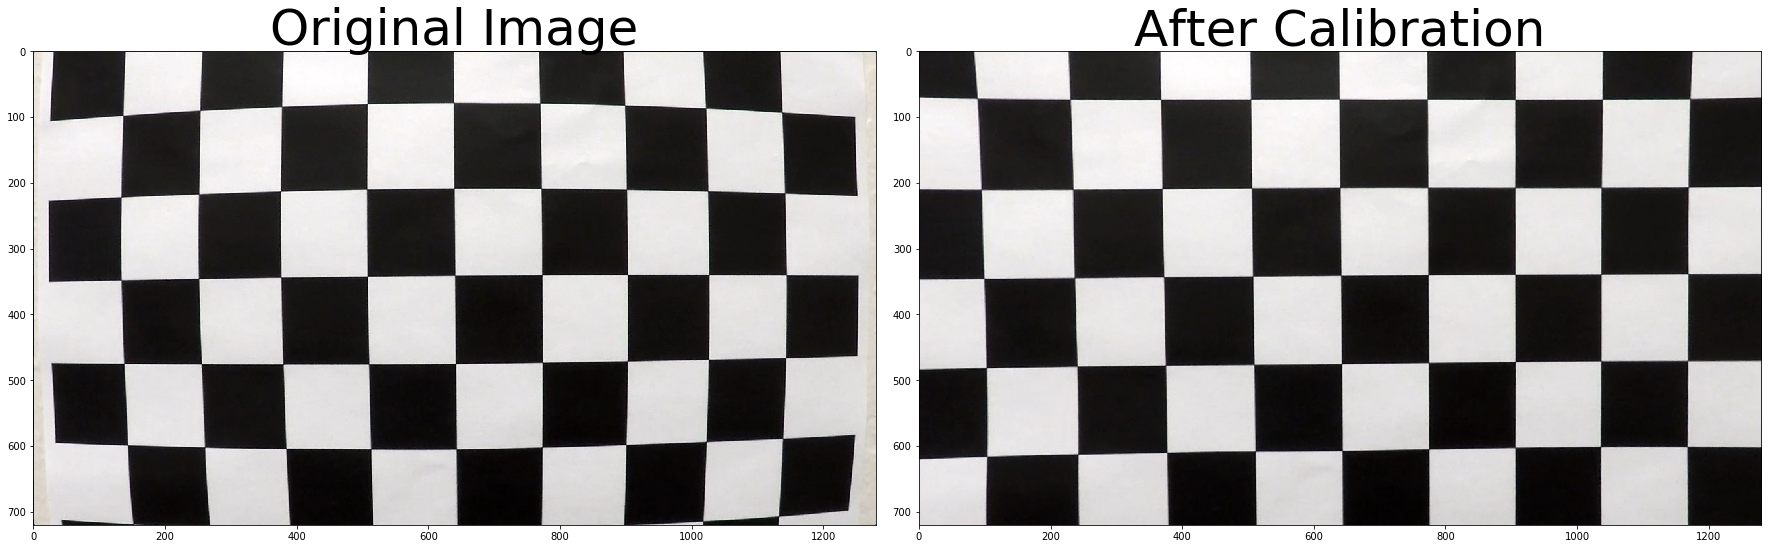

In [4]:
original_image = mpimg.imread(images[0])
undistorted_image = undistort_camera_image(original_image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(original_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_image)
ax2.set_title('After Calibration', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [5]:
def pre_process_image(input_image, s_thresh=(150, 255), l_thresh=(120,255), sx_thresh=(30, 100)):
    undistorted_image = undistort_camera_image(input_image)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
      
    # Threshold 
    final_binary = np.zeros_like(s_channel)
    final_binary[np.logical_or((s_channel > s_thresh[0]) & (s_channel < s_thresh[1]) & (l_channel > l_thresh[0]) & (l_channel < l_thresh[1]) , (scaled_sobel > sx_thresh[0]) & (scaled_sobel <= sx_thresh[1]))] = 1
    
    height = input_image.shape[0]
    width = input_image.shape[1]
    
    mask = np.zeros_like(final_binary)
    region_of_interest_vertices = np.array([[100,height-1], [width/2, int(height/2)], [width-100, height-1]], dtype=np.int32)
        

    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    binary_hls = cv2.bitwise_and(final_binary, mask)
    
    return binary_hls

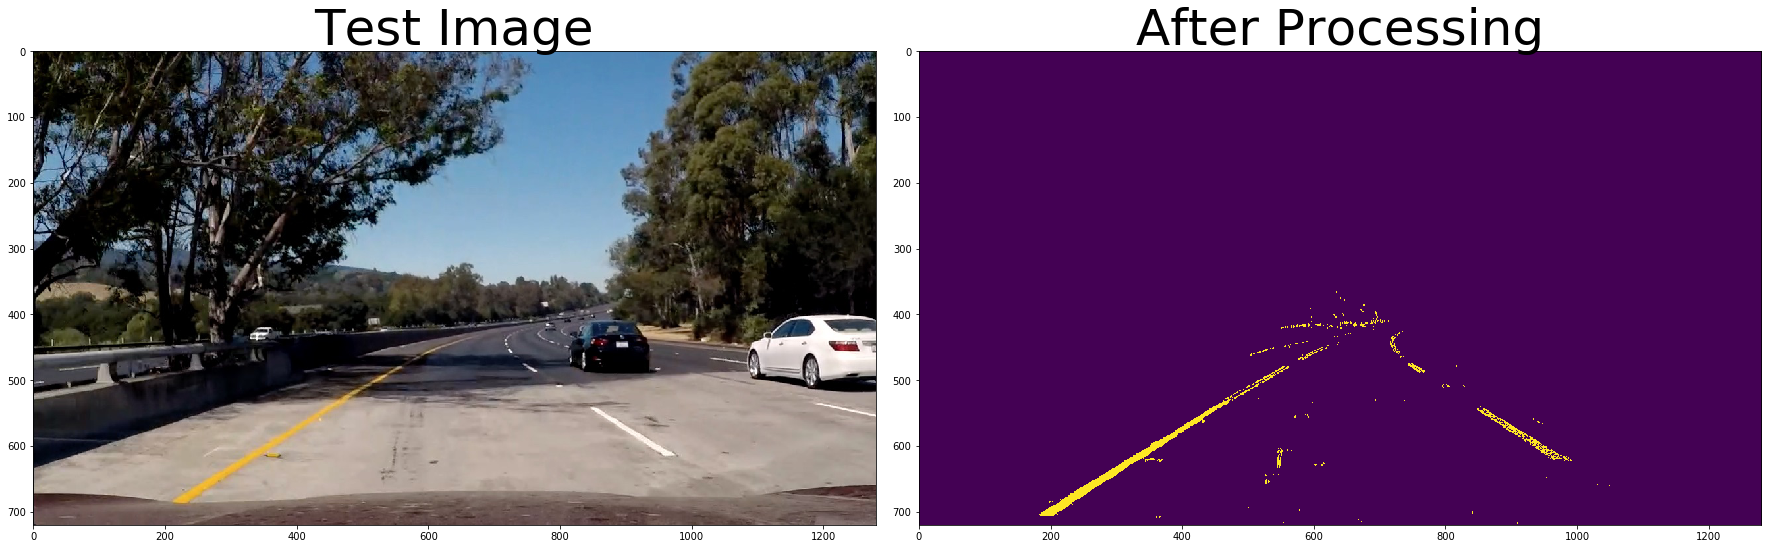

In [6]:
test_image = mpimg.imread('test_images/test5.jpg')
pre_processed_image = pre_process_image(test_image, s_thresh=(150, 255), l_thresh=(120,255), sx_thresh=(20, 100))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Test Image', fontsize=50)
ax2.imshow(pre_processed_image)
ax2.set_title('After Processing', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [7]:
def apply_perspective_transformation(input_image, reverse_perspective=False, src = np.float32([[200,720], [600, 447], [679,447], [1100,720]]), dst = np.float32([[300, 720], [300, 0], [900, 0], [900, 720]]) ):
    
    
    # For source points I'm grabbing the outer four detected corners
    img_size = (input_image.shape[1], input_image.shape[0])
    # Given src and dst points, calculate the perspective transform matrix
    M = None
    if reverse_perspective:
        M = cv2.getPerspectiveTransform(dst, src)
    else:
        M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(input_image, M, img_size)
    # Warp the image using OpenCV warpPerspective()
    return warped

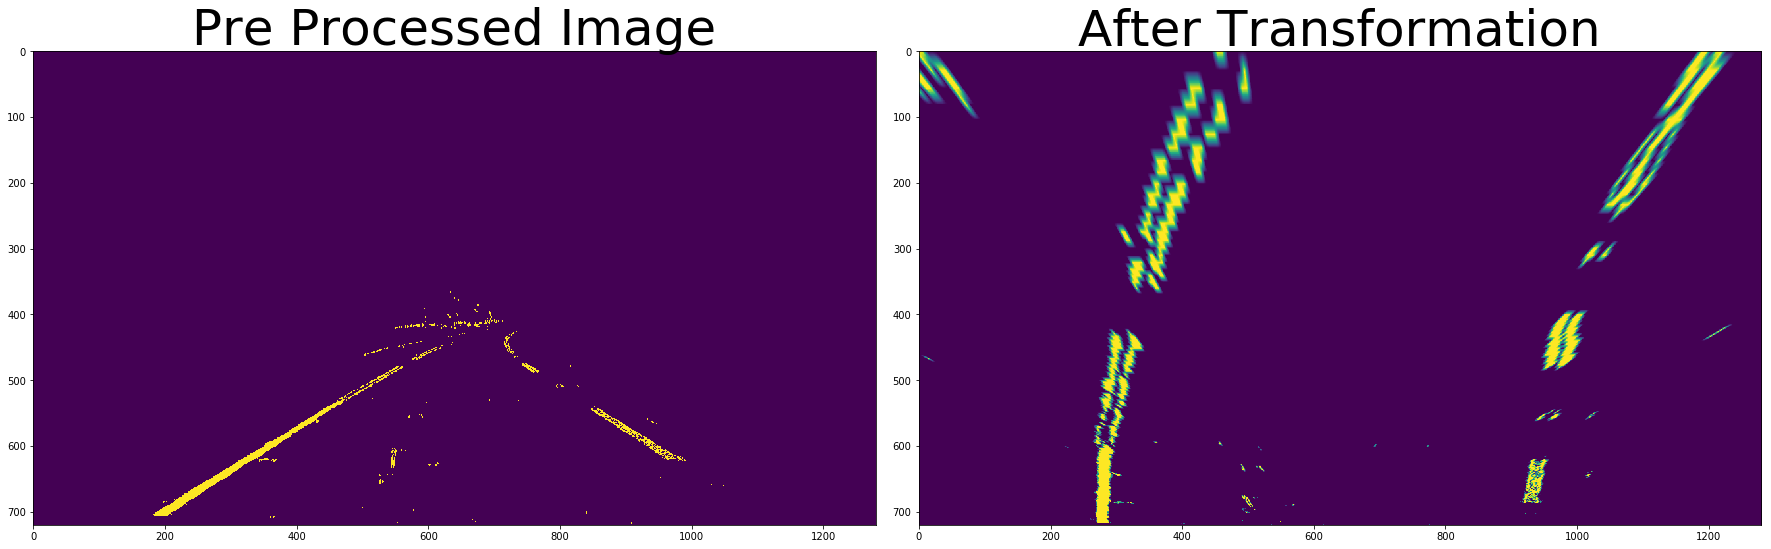

In [8]:
#     src = np.float32([[270,672], [540, 490], [748,490], [1030,672]])
# src = np.float32([[270,672], [621, 448], [717,442], [1030,672]])
# src = np.float32([[270,672], [620, 440], [720,430], [1030,672]])
src = np.float32([[200,720], [600, 447], [679,447], [1100,720]])
dst = np.float32([[300, 720], [300, 0], [900, 0], [900, 720]])
after_perspective_transformation = apply_perspective_transformation(pre_processed_image,False, src, dst)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(pre_processed_image)
ax1.set_title('Pre Processed Image', fontsize=50)
ax2.imshow(after_perspective_transformation)
ax2.set_title('After Transformation', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

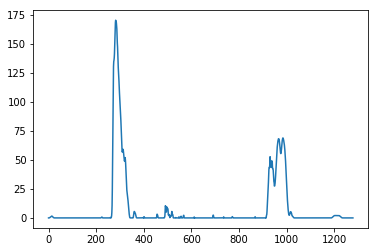

In [9]:
histogram = np.sum(after_perspective_transformation[after_perspective_transformation.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [10]:
def radious_of_curvature(fitx, length):
    ploty = np.linspace(0, length-1, length )
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    return ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

In [11]:
def apply_sliding_window_search(warped_image, input_prev_left_fit, input_prev_right_fit):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(after_perspective_transformation[after_perspective_transformation.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    binary_warped = warped_image.astype(np.uint8)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped_image, warped_image, warped_image))
    window_img = np.zeros_like(out_img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
   
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    input_prev_left_fit.append(left_fit)
    input_prev_right_fit.append(right_fit)
    
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    new_margin = (right_fitx-left_fitx)/2
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+new_margin+50, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-new_margin-50, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    result=apply_perspective_transformation(result, True)
    
    left_curverad = radious_of_curvature(left_fitx, result.shape[0])
    right_curverad = radious_of_curvature(right_fitx, result.shape[0])
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Radius of Curvature = {0:.3f}(m)'.format(np.mean([left_curverad,right_curverad])),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    lane_center = (right_fitx[result.shape[0]-1] + left_fitx[result.shape[0]-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = result.shape[1]/2 - lane_center
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    if center_offset_mtrs>=0:
        towards = 'left'
    else:
        towards = 'right'
    cv2.putText(result,'Vehicle is {0:.3f}m '.format(abs(center_offset_mtrs))+towards+' of center',(50,100), font, 1,(255,255,255),2,cv2.LINE_AA)
#     cv2.putText(result, 'Centre: ' + str(right_fitx[-1] - left_fitx[-1]), (230, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
#     plt.imshow(result)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
#     pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
#     pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
#     pts = np.hstack((pts_left, pts_right))
#     cv2.fillPoly(out_img,pts,(0,255, 0))
#     cv2.fillPoly(window_img, np.int_([left_lane_inds]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#     plt.plot(left_fitx, ploty, color='red')
#     plt.plot(right_fitx, ploty, color='red')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
#     plt.imshow(out_img)

    
    return result

In [12]:
def skip_sliding_window_search(warped_image, input_left_fit, input_right_fit):
    
    left_fit  = np.mean(input_left_fit[-10:], axis=0)
    right_fit = np.mean(input_right_fit[-10:], axis = 0)
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    binary_warped = warped_image.astype(np.uint8)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    new_margin = (right_fitx-left_fitx)/2
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+new_margin+50, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-new_margin-50, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    result=apply_perspective_transformation(result, True)
    
    left_curverad = radious_of_curvature(left_fitx, result.shape[0])
    right_curverad = radious_of_curvature(right_fitx, result.shape[0])
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Radius of Curvature = {0:.3f}(m)'.format(np.mean([left_curverad,right_curverad])),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    lane_center = (right_fitx[result.shape[0]-1] + left_fitx[result.shape[0]-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = result.shape[1]/2 - lane_center
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    if center_offset_mtrs>=0:
        towards = 'left'
    else:
        towards = 'right'
    cv2.putText(result,'Vehicle is {0:.3f}m '.format(abs(center_offset_mtrs))+towards+' of center',(50,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    input_left_fit.append(left_fit)
    input_right_fit.append(right_fit)
    
    return result

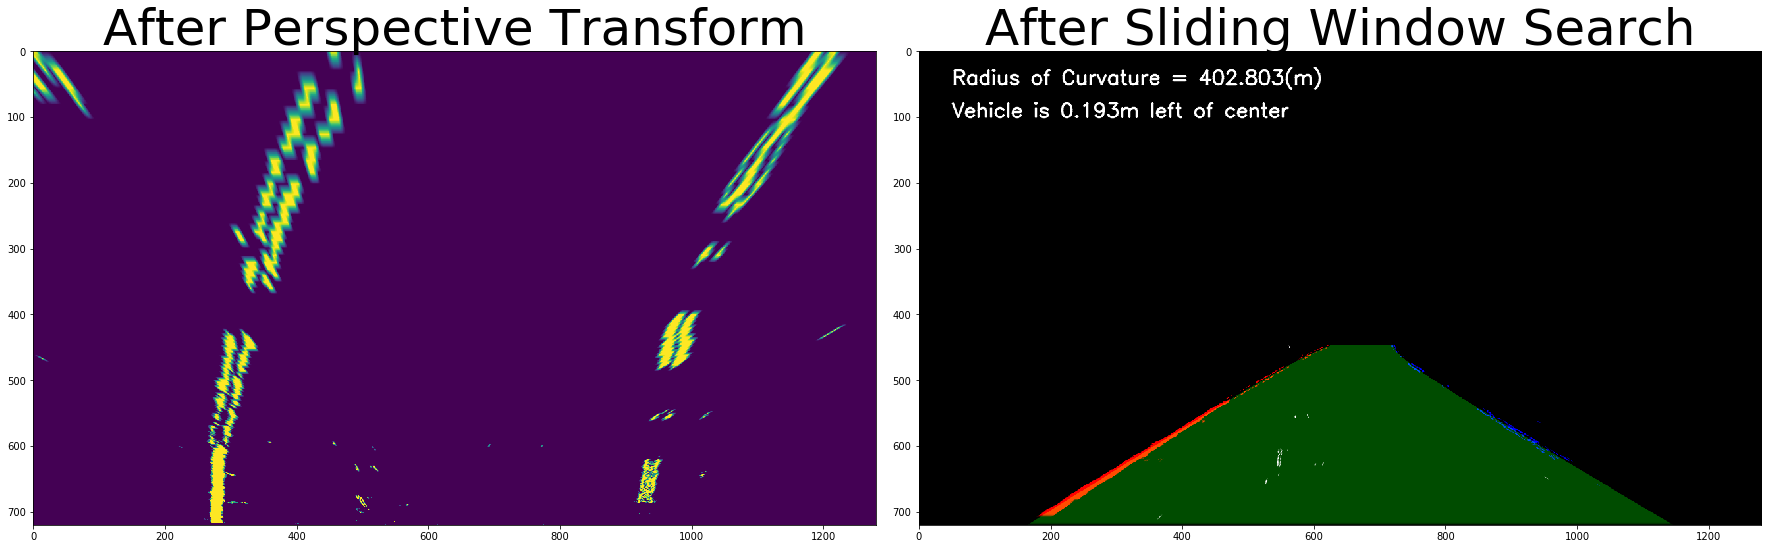

In [13]:

#     src = np.float32([[270,672], [540, 490], [748,490], [1030,672]])
left = []
right = []
result = apply_sliding_window_search(after_perspective_transformation, left, right)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(after_perspective_transformation)
ax1.set_title('After Perspective Transform', fontsize=50)
ax2.imshow(result, cmap='hsv')
ax2.set_title('After Sliding Window Search', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

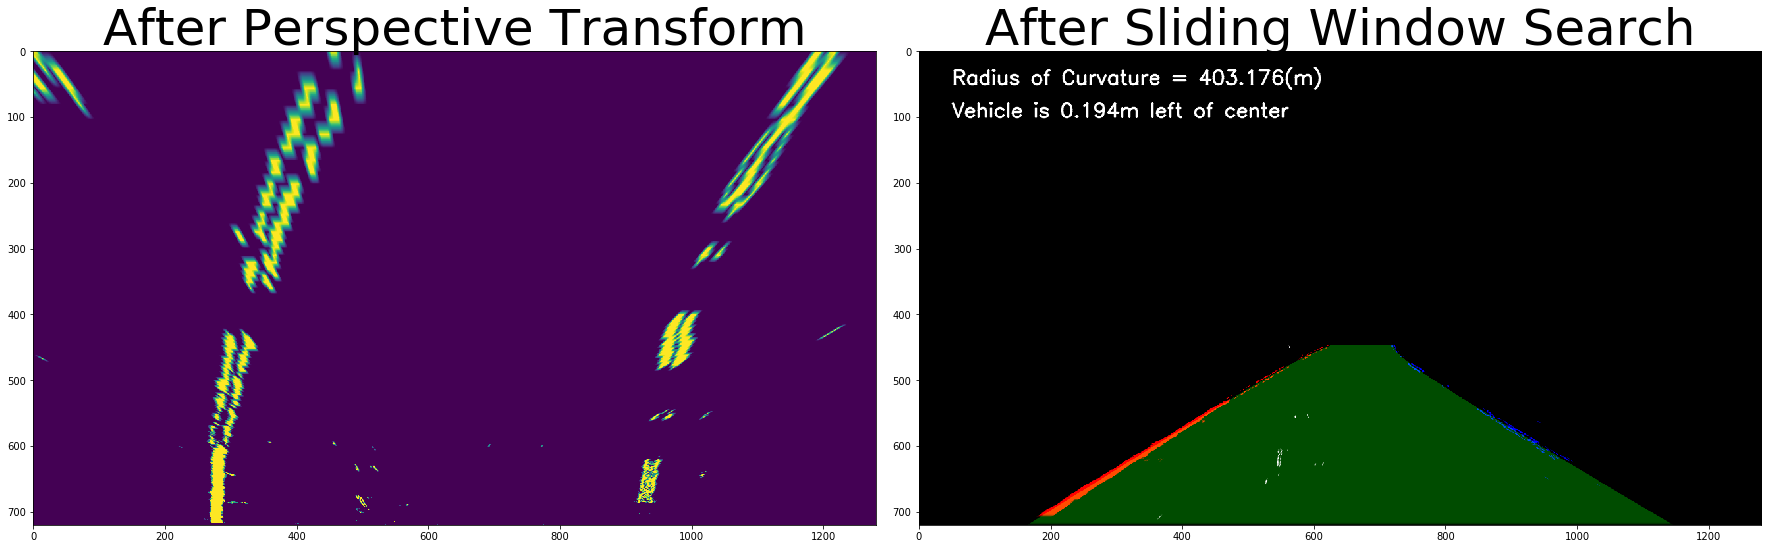

In [14]:
result = skip_sliding_window_search(after_perspective_transformation, left, right)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(after_perspective_transformation)
ax1.set_title('After Perspective Transform', fontsize=50)
ax2.imshow(result, cmap='hsv')
ax2.set_title('After Sliding Window Search', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

class MyVideoProcessor(object):
    prev_left_fit = []
    prev_right_fit = []
    
    def pipeline(self, image):
        pre_processed_img = pre_process_image(image, s_thresh=(150, 255), l_thresh=(120,255), sx_thresh=(20, 100))
        after_perspective = apply_perspective_transformation(pre_processed_img)
        
        result = None
        if len(self.prev_left_fit) < 10:
            result = apply_sliding_window_search(after_perspective, self.prev_left_fit, self.prev_right_fit)
        else:
            result = skip_sliding_window_search(after_perspective, self.prev_left_fit, self.prev_right_fit)
        result = cv2.addWeighted(image, 1, result, 0.7, 0)
        return result
    
video_processor = MyVideoProcessor()



output = 'project_video_output_new.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video_processor.pipeline)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output_new.mp4
[MoviePy] Writing video project_video_output_new.mp4


  7%|█████▍                                                                          | 86/1261 [00:22<05:12,  3.76it/s]

In [ ]:
print(video_processor.prev_left_fit)
print("aA")

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))